In [1]:
!unzip classify-leaves.zip

  inflating: images/9101.jpg         
  inflating: images/9102.jpg         
  inflating: images/9103.jpg         
  inflating: images/9104.jpg         
  inflating: images/9105.jpg         
  inflating: images/9106.jpg         
  inflating: images/9107.jpg         
  inflating: images/9108.jpg         
  inflating: images/9109.jpg         
  inflating: images/911.jpg          
  inflating: images/9110.jpg         
  inflating: images/9111.jpg         
  inflating: images/9112.jpg         
  inflating: images/9113.jpg         
  inflating: images/9114.jpg         
  inflating: images/9115.jpg         
  inflating: images/9116.jpg         
  inflating: images/9117.jpg         
  inflating: images/9118.jpg         
  inflating: images/9119.jpg         
  inflating: images/912.jpg          
  inflating: images/9120.jpg         
  inflating: images/9121.jpg         
  inflating: images/9122.jpg         
  inflating: images/9123.jpg         
  inflating: images/9124.jpg         
  inflating:

In [1]:
import paddle
from paddle.io import Dataset
import paddle.vision.transforms as T
from PIL import Image

class LeaveDataset(Dataset):
    def __init__(self, x, y, train=True):
        self.x = x
        self.y = y
        self.train = train
        self.train_trans = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(180, fill=(255, 255, 255)),
            T.ColorJitter(brightness=0.5),
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.other_trans = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        x = Image.open('./' + x)
        if self.train:
            x = self.train_trans(x)
        else:
            x = self.other_trans(x)

        return x, y

    def __len__(self):
        return len(self.x)


In [2]:
x = ["images/0.jpg", "images/1.jpg"]  # 示例图像文件名
y = [0, 1]  # 示例标签

train_dataset = LeaveDataset(x, y, train=True)

# 获取数据
for img, label in train_dataset:
    print(img.shape, label)

[3, 224, 224] 0
[3, 224, 224] 1


W0706 13:17:56.050933   244 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0706 13:17:56.052417   244 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from paddle.io import DataLoader

TEST_SIZE = 0.2
BATCH_SIZE = 64

# 加载训练数据
def load_train_data():
    data = pd.read_csv('./train.csv')
    
    x, y = data['image'], data['label']
    print(f'x={len(x)}, y={len(y)}')
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = y.astype('int32')
    
    train_x, valid_x, train_y, valid_y = train_test_split(
        x, y, test_size=TEST_SIZE, random_state=66, shuffle=True, stratify=y)
    print(f'train={len(train_x)}, valid={len(valid_x)}')
    
    train_ds = LeaveDataset(train_x.values, train_y)
    valid_ds = LeaveDataset(valid_x.values, valid_y, train=False)
    print(f'train={len(train_ds)}, valid={len(valid_ds)}')
    
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
    print(f'train={len(train_dl)}, valid={len(valid_dl)}')
    
    return train_dl, valid_dl, le

In [4]:
train_dl, valid_dl, le = load_train_data()

x=18353, y=18353
train=14682, valid=3671
train=14682, valid=3671
train=230, valid=58


In [5]:
import paddle
import paddle.nn as nn
import paddle.vision.models as models

# 加载预训练的ResNet18模型
model = models.resnet18()

# 获取全连接层的输入特征数
in_features = model.fc.weight.shape[0]

# 修改全连接层
model.fc = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.BatchNorm1D(128),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(128, len(le.classes_))
)

# 打印模型结构
print(model)

ResNet(
  (conv1): Conv2D(3, 64, kernel_size=[7, 7], stride=[2, 2], padding=3, data_format=NCHW)
  (bn1): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
  (relu): ReLU()
  (maxpool): MaxPool2D(kernel_size=3, stride=2, padding=1)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
      (bn1): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
      (relu): ReLU()
      (conv2): Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
      (bn2): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
    )
    (1): BasicBlock(
      (conv1): Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
      (bn1): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
      (relu): ReLU()
      (conv2): Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
      (bn2): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
    )
  )
  (layer2): Sequential(
    (0): Bas

In [6]:
import paddle.nn.functional as F
import paddle.optimizer as opt
from nndl import RunnerV3, Accuracy

#指定运行设备
use_gpu = True if paddle.get_device().startswith("gpu") else False
if use_gpu:
    paddle.set_device('gpu:0')
#学习率大小
lr = 0.001  
#定义优化器，
optimizer = opt.Adam(learning_rate=lr, parameters=model.parameters(), weight_decay=0.005)
#定义损失函数
loss_fn = F.cross_entropy
#定义评价指标
metric = Accuracy(is_logist=True)
#实例化RunnerV3
runner = RunnerV3(model, optimizer, loss_fn, metric)
#启动训练
log_steps = 100
eval_steps = 1000
runner.train(train_dl, valid_dl, num_epochs=50, log_steps=log_steps, 
                eval_steps=eval_steps, save_path="best_model.pdparams")

/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:788: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


[Train] epoch: 0/50, step: 0/11500, loss: 5.57582
[Evaluate]  dev_score: 0.00354, dev_loss: 166.97829
best accuracy performence has been updated: 0.00000 --> 0.00354
[Train] epoch: 0/50, step: 100/11500, loss: 4.96939
[Train] epoch: 0/50, step: 200/11500, loss: 4.73333
[Train] epoch: 1/50, step: 300/11500, loss: 4.49833
[Train] epoch: 1/50, step: 400/11500, loss: 4.17789
[Train] epoch: 2/50, step: 500/11500, loss: 4.07829
[Train] epoch: 2/50, step: 600/11500, loss: 4.11844
[Train] epoch: 3/50, step: 700/11500, loss: 4.02351
[Train] epoch: 3/50, step: 800/11500, loss: 4.15456
[Train] epoch: 3/50, step: 900/11500, loss: 3.93769
[Train] epoch: 4/50, step: 1000/11500, loss: 3.89801
[Evaluate]  dev_score: 0.02206, dev_loss: 5.04881
best accuracy performence has been updated: 0.00354 --> 0.02206
[Train] epoch: 4/50, step: 1100/11500, loss: 3.79764
[Train] epoch: 5/50, step: 1200/11500, loss: 3.98080
[Train] epoch: 5/50, step: 1300/11500, loss: 3.70761
[Train] epoch: 6/50, step: 1400/11500, l

KeyboardInterrupt: 

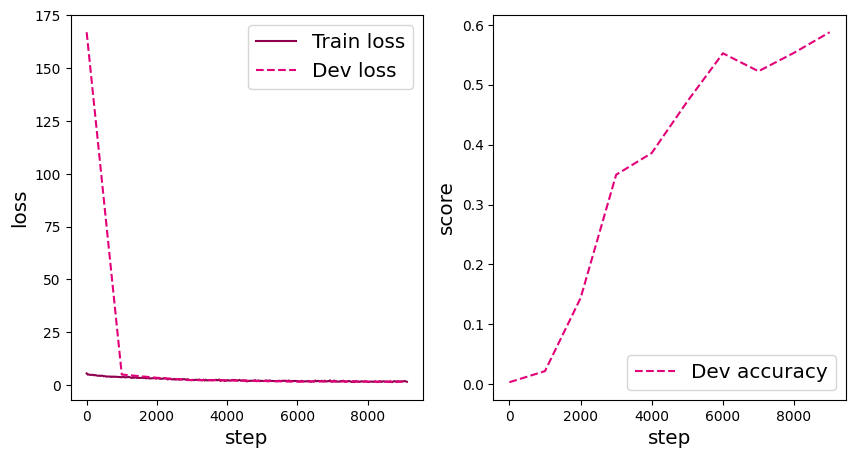

In [7]:
from nndl import plot

plot(runner, fig_name='cnn-loss4.pdf')

In [13]:
# 加载测试数据
data = pd.read_csv('./test.csv')

x = data['image']
print(f'x={len(x)}')

# 创建测试数据集和数据加载器
test_ds = LeaveDataset(x.values, x.values, train=False)
print(f'test={len(test_ds)}')

test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=1)
print(f'test={len(test_dl)}')

labels = []

# 模型推理
for x, _ in test_dl:
    x = paddle.to_tensor(x)  # 确保数据是tensor类型
    y = runner.predict(x)
    y = paddle.argmax(y, axis=1)
    y = le.inverse_transform(y.numpy())  # 将预测的索引转换回标签
    
    for l in y:
        labels.append(l)
        
# 保存结果
submission = data
submission['label'] = labels
submission.to_csv('./submission.csv', index=False)

x=8800
test=8800
test=138
